In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, NonlinearConstraint

# Differential Evolution: An alternative to convex optimization

Throughout four problems will be solved to demonstrate applications of Differential Evolution.

1) A quadratic convex problem, that can be successfully solved by convex methods.

2) Nonconvex modification of the third by adding rugosity terms.

3) Real valued a modified engineering design problem in continuous variables, in which some algorithms might be ineffective.

4) Original engineering design problem, which is non-differentiable, by adding modifications of discrete variables. 

## 1) Convex problem

In [2]:
#Defining the objective function
def obj_fun(x):

    return (x[0] - 0.5) ** 2 + 0.7 * x[0] * x[1] + 1.2 * (x[1] + 0.7) ** 2

#Defining the gradient function
def gradient_fun(x):
    
    return np.array([2 * (x[0] - 0.5) + 0.7 * x[1], 0.7 * x[0] + 2 * 1.2 * (x[1] + 0.7)])

#Defining the Hessian function
def hess_fun(x):
    
    return np.array([[2., 0.7],
                     [0.7, 2. * 1.2]])

In [3]:
true_optima = - np.linalg.solve(hess_fun([0, 0]), gradient_fun([0, 0]))
print(true_optima)

[ 0.82969838 -0.94199536]


In [4]:
#Creating a countouf plot
x1 = np.linspace(-5, 5, 100)
x2 = np.linspace(-5, 5, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.vstack((X1.flatten().reshape([1, -1]), X2.flatten().reshape([1, -1])))
F = np.array([obj_fun(x) for x in X.T])
F = F.reshape([100, 100])

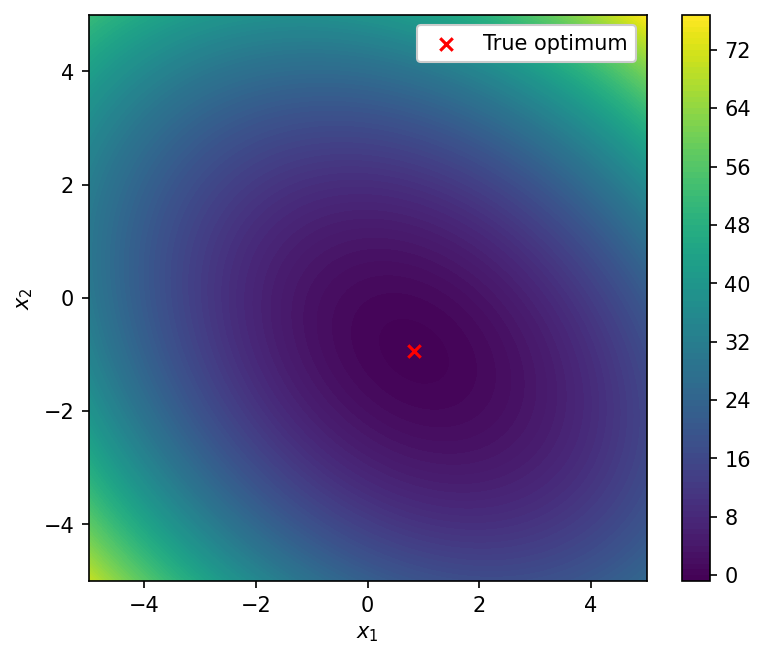

In [5]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, F, levels=100)
fig.colorbar(surf, shrink=1.0, aspect=20)

ax.scatter([true_optima[0]],  [true_optima[1]], marker="x", color="red", label="True optimum")
ax.legend(framealpha=1.0)

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

plt.show()

In [6]:
#Optimization using BFGS (gradient-based method)
sol_cvx = minimize(obj_fun, [2.5, 0.0], jac=gradient_fun, method="BFGS")
print(sol_cvx)

      fun: -0.36812529002319994
 hess_inv: array([[ 0.55803677, -0.16377684],
       [-0.16377684,  0.4655973 ]])
      jac: array([ 3.96473135e-08, -6.76248182e-08])
  message: 'Optimization terminated successfully.'
     nfev: 7
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([ 0.82969841, -0.9419954 ])


In [7]:
#Otimization using Differential Evolution
sol_de = differential_evolution(obj_fun, bounds=[(-5., 5.), (-5., 5.)],
                                popsize=50, strategy="rand1bin", mutation=(0.3, 1.0), recombination=0.7,
                                tol=1e-8, maxiter=200, updating="deferred", polish=False)

print(sol_de)

     fun: -0.3681252899527092
 message: 'Optimization terminated successfully.'
    nfev: 5300
     nit: 52
 success: True
       x: array([ 0.82970396, -0.94200294])


Final solutions are basically the same, and both converged to the known optima. However, Differential Evolution took way more function evaluations than SLSQP.

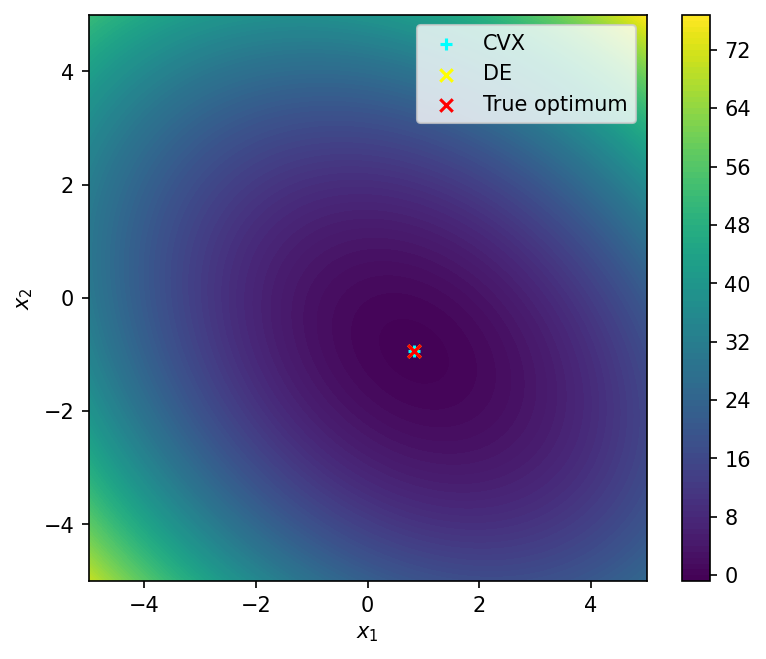

In [8]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, F, levels=100)
fig.colorbar(surf, shrink=1.0, aspect=20)

ax.scatter([sol_cvx.x[0]],  [sol_cvx.x[1]], marker="+", color="cyan", label="CVX")
ax.scatter([sol_de.x[0]],  [sol_de.x[1]], marker="x", color="yellow", label="DE")
ax.scatter([true_optima[0]],  [true_optima[1]], marker="x", color="red", label="True optimum")
ax.legend()

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

plt.show()

## 2) Nonconvex variant

In [9]:
#In the nonconvex problem we add some periodical terms
def obj_fun_2(x):
    
    A = np.array([[1, 0.3],
                  [0.3, 0.7]])
    
    xt = x.dot(A)
    
    rugosity_1 = (xt[0] * np.sin(15 * xt[0]) - 0.5) ** 2 + (xt[1] * np.sin(15 * xt[1]) - 2) ** 2
    rugosity_2 = np.sin(15 * x[0]) ** 2 + np.sin(25 * x[1]) ** 2
    convex = obj_fun(x)
    
    return 5 * rugosity_2 + rugosity_1 + convex

In [10]:
#And create a more detailed mesh
n_mesh = 300
x1 = np.linspace(-5, 5, n_mesh)
x2 = np.linspace(-5, 5, n_mesh)
X1, X2 = np.meshgrid(x1, x2)
X = np.vstack((X1.flatten().reshape([1, -1]), X2.flatten().reshape([1, -1])))
F = np.array([obj_fun_2(x) for x in X.T])
F = F.reshape([n_mesh, n_mesh])

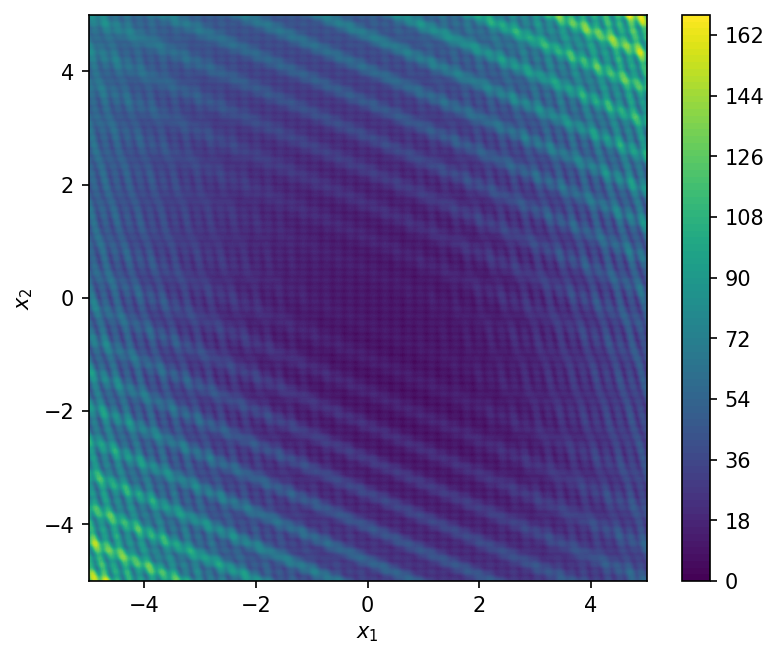

In [11]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, F, levels=100)
fig.colorbar(surf, shrink=1.0, aspect=20)

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

plt.show()

In [12]:
#And BFGS has got stuck in a local optima near the initial guess
sol_cvx_2 = minimize(obj_fun_2, [2.5, 0.0], method="BFGS")
print(sol_cvx_2)

      fun: 12.117598099070367
 hess_inv: array([[ 2.04453980e-04, -2.29788954e-05],
       [-2.29788954e-05,  1.68925094e-04]])
      jac: array([-9.53674316e-07,  3.45706940e-06])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 5
     njev: 11
   status: 0
  success: True
        x: array([2.52056115e+00, 2.09959108e-03])


In [13]:
%%time
#Whereas differential evolution converged to a much better solution
sol_de_2 = differential_evolution(obj_fun_2, bounds=[(-5., 5.), (-5., 5.)],
                                popsize=50, strategy="rand1bin", mutation=(0.2, 1.0), recombination=0.7,
                                tol=1e-8, maxiter=200, updating="deferred", polish=False)

print(sol_de_2)

     fun: 1.6129353839556069
 message: 'Optimization terminated successfully.'
    nfev: 15800
     nit: 157
 success: True
       x: array([ 0.62909596, -1.63297731])
CPU times: total: 1.31 s
Wall time: 1.32 s


The tolarance used was problematic on purpose so that the algorithm would run for 200 generations. No violations and a musch better result on ~ 20k function evaluations and a wall time of almost 2s.

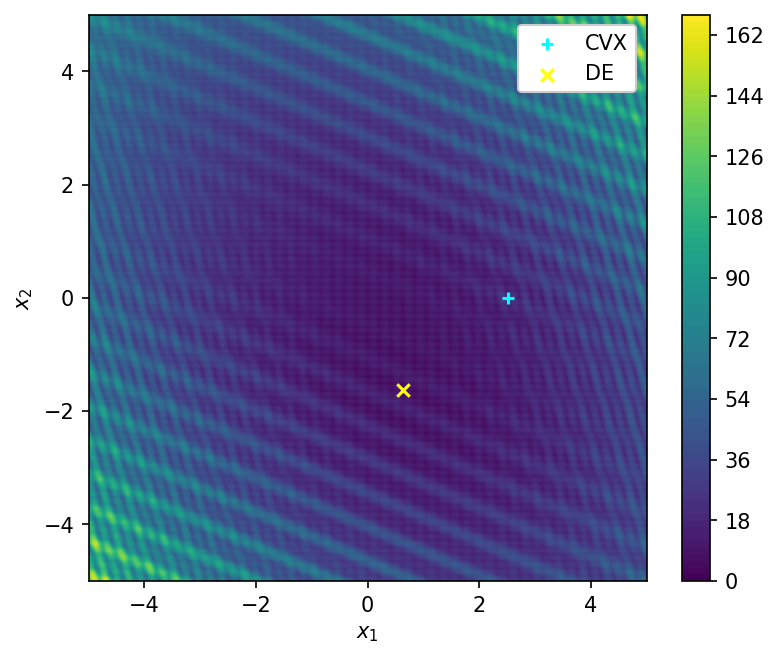

In [14]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, F, levels=100)
fig.colorbar(surf, shrink=1.0, aspect=20)

ax.scatter([sol_cvx_2.x[0]],  [sol_cvx_2.x[1]], marker="+", color="cyan", label="CVX")
ax.scatter([sol_de_2.x[0]],  [sol_de_2.x[1]], marker="x", color="yellow", label="DE")
ax.legend(framealpha=1.0)

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

plt.show()

In [15]:
#Now let us create several random initial guesses in the decision space and see how it goes
np.random.seed(1)
X1_guess = -5 + 10 * np.random.random(500)
X2_guess = -5 + 10 * np.random.random(500)

In [16]:
%%time
#Initial values for best solutions
fopt_2 = np.inf
xopt_2 = np.array([np.nan, np.nan])

#At each step, if a better solution is found it replaces the current best
#500 times
for i in range(500):
    sol_scipy_i = minimize(obj_fun_2, [X1_guess[i], X2_guess[i]], method="BFGS")

    if sol_scipy_i.success:
        if sol_scipy_i.fun < fopt_2:
            fopt_2 = sol_scipy_i.fun
            xopt_2 = sol_scipy_i.x

CPU times: total: 3.53 s
Wall time: 3.57 s


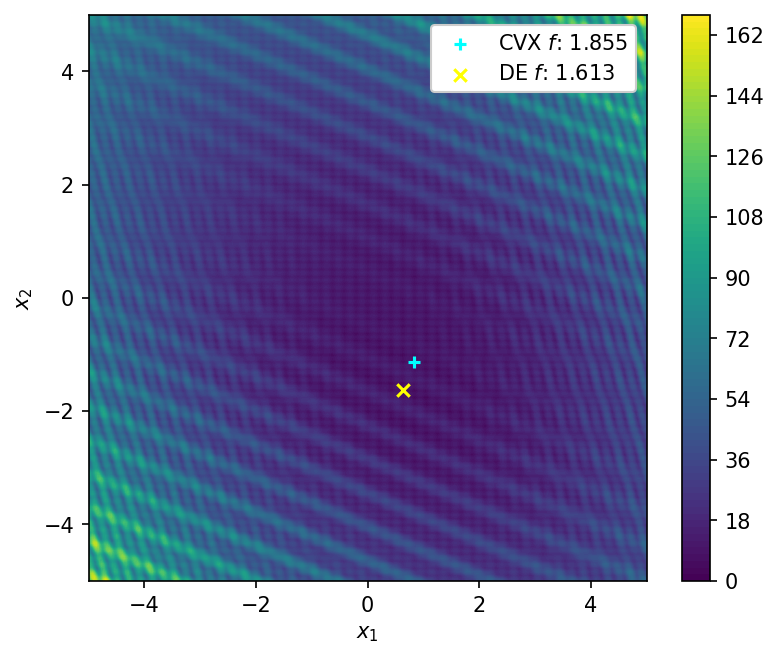

In [17]:
fig, ax = plt.subplots(figsize=[6, 5], dpi=150)

surf = ax.contourf(X1, X2, F, levels=100)
fig.colorbar(surf, shrink=1.0, aspect=20)

ax.scatter([xopt_2[0]],  [xopt_2[1]], marker="+", color="cyan", label=f"CVX $f$: {fopt_2:.3f}")
ax.scatter([sol_de_2.x[0]],  [sol_de_2.x[1]], marker="x", color="yellow", label=f"DE $f$: {sol_de_2.fun:.3f}")
ax.legend(framealpha=1.0)

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

plt.show()

With 500 different initial guesses (and a greater wall time), SLSQP could find a solution closer to the one found by DE in the decision space (probably the global optima). However, we can notice that it still got stuck in a local optima, of which the function value for practical purposes might have been considerably worse than desired.

In more sparse spaces, this is likely to become more evident, as providing good initial estimations becomes harder.

## 3) Pressure vessel design: Real valued

For more details, see:

Lampinen, J. & Storn, R., 2004. Differential Evolution. In: New Optimization Techniques in Engineering. Berlin, Heidelberg: Springer, pp. 123-166.\
Sandgren, E., 1990. Nonlinear integer and discrete programming in mechanical design optimization. Journal of Mechanical Design, 112(2), pp. 223-229.

**minimize**

$f(\boldsymbol{x}) = 0.6224 x_1 x_3 x_4 + 1.7781 x_2 x_3^2 + 3.1611 x_1^2 x_4 + 19.84 x_1^2 x_3$

**subject to**

$g_1(\boldsymbol{x}) \equiv 0.0193 x_3 - x_1 \leq 0\\$
$g_2(\boldsymbol{x}) \equiv 0.00954 x_3 - x_2 \leq 0\\$
$g_3(\boldsymbol{x}) \equiv 750 \times 1728 - \pi x_3^2 x_4 - \frac{4}{3} \pi x_3^3 \leq 0$

**boundaries**

$1.1 \leq x_1 \leq 12.5\\$
$0.6 \leq x_2 \leq 12.5\\$
$0.0 \leq x_3 \leq 240\\$
$0.0 \leq x_4 \leq 240\\$

**gradient information**

\begin{align*}
&\nabla f(\boldsymbol{x}) =
\begin{bmatrix}
    0.6224 x_3 x_4 + 6.3222 x_1 x_4 + 39.68 x_1 x_3\\
    1.7781 x_3^2 \\
    0.6224 x_1 x_4 + 3.5562 x_2 x_3 + 19.84 x_1^2\\
    0.6224 x_1 x_3 + 3.1611 x_1^2
\end{bmatrix} \\
&\nabla g_1(\boldsymbol{x}) =
\begin{bmatrix}
    -1 \leq 0\\
    0 \\
    0.0193\\
    0
\end{bmatrix} \\
&\nabla g_2(\boldsymbol{x}) =
\begin{bmatrix}
    0 \leq 0\\
    -1 \\
    0.00954\\
    0
\end{bmatrix} \\
&\nabla g_3(\boldsymbol{x}) =
\begin{bmatrix}
    0\\
    0\\
    -2 \pi x_3 x_4 - 4 \pi x_3^2\\
    -\pi x_3^2
\end{bmatrix} \\
\end{align*}

In [18]:
def f_vessel(x):
    
    return 0.6224 * x[0] * x[2] * x[3] + 1.7781 * x[1] * x[2] ** 2 + 3.1611 * x[0] ** 2 * x[3] + 19.84 * x[0] ** 2 * x[2]

def grad_vessel(x):
    
    return np.array([0.6224 * x[2] * x[3] + 6.3222 * x[0] * x[3] + 39.68 * x[0] * x[2],
                     1.7781 * x[2] ** 2,
                     0.6224 * x[0] * x[3] + 3.5562 * x[1] * x[2] + 19.84 * x[0] ** 2,
                     0.6224 * x[0] * x[2] + 3.1611 * x[0] ** 2])
    
def c1_vessel(x):
    return - (0.0193 * x[2] - x[0])

def c2_vessel(x):
    return - (0.00954 * x[2] - x[1])

def c3_vessel(x):
    return - (750 * 1728 - np.pi * x[2] ** 2 * x[3] - 4/3 * np.pi * x[2] ** 3)

def c1_grad(x):
    
    return np.array([1,
                     0,
                     -0.0193,
                     0])

def c2_grad(x):
    
    return np.array([0,
                     1,
                     -0.00954,
                     0])

def c3_grad(x):
    
    return np.array([0,
                     0,
                     (2 * np.pi * x[2] * x[3] + 4 * np.pi * x[2] ** 2),
                     np.pi * x[2] ** 2])

In [19]:
c1 = NonlinearConstraint(c1_vessel, 0.0, np.inf, jac=c1_grad)
c2 = NonlinearConstraint(c2_vessel, 0.0, np.inf, jac=c2_grad)
c3 = NonlinearConstraint(c3_vessel, 0.0, np.inf, jac=c3_grad)

cons_vessel = [c1, c2, c3]

In [20]:
bounds_vessel = [(1.1, 12.5), (0.6, 12.5), (0.0, 240.0), (0.0, 240.0)]

### Convex approach

In [21]:
sol_cvx_vessel = minimize(f_vessel, [2, 2, 50, 50], jac=grad_vessel,
                          bounds=bounds_vessel, constraints=cons_vessel, 
                          method="SLSQP"
                          )

print(sol_cvx_vessel)

     fun: 7019.030796129131
     jac: array([4651.59055536, 5775.99638457,  180.53487774,   42.84586267])
 message: 'Positive directional derivative for linesearch'
    nfev: 17
     nit: 11
    njev: 7
  status: 8
 success: False
       x: array([ 1.1       ,  0.6       , 56.99481724, 51.00125073])


In [22]:
for c in (c1_vessel, c2_vessel, c3_vessel):
    print(c(sol_cvx_vessel.x))

2.72788380772937e-08
0.056269443535757246
-0.09380692627746612


Functional constraints were violated...

In [23]:
sol_tr_vessel = minimize(f_vessel, [2, 2, 50, 50], jac=grad_vessel,
                          bounds=bounds_vessel, constraints=cons_vessel, 
                          method="trust-constr"
                          )

print(sol_tr_vessel)

 barrier_parameter: 0.0008000000000000003
 barrier_tolerance: 0.0008000000000000003
          cg_niter: 43
      cg_stop_cond: 1
            constr: [array([2.28515401e-07]), array([0.05626934]), array([0.19054379]), array([ 1.1000007 ,  0.60000014, 56.99484302, 51.00112934])]
       constr_nfev: [34, 34, 34, 0]
       constr_nhev: [0, 0, 0, 0]
       constr_njev: [34, 34, 34, 0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 0.1111302375793457
               fun: 7019.034299531395
              grad: array([4651.58915419, 5776.00160963,  180.53493039,   42.84590997])
               jac: [array([[ 1.    ,  0.    , -0.0193,  0.    ]]), array([[ 0.     ,  1.     , -0.00954,  0.     ]]), array([[    0.        ,     0.        , 59084.72234028, 10205.18768569]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])]
   lagrangian_grad: array([ 4.09272616e-12,  9.09494702e-13,  2.03218216e-10, -1.17668838e-09])
           m

c:\Users\Bruno\OneDrive\Área de Trabalho\Python Packages\mooscalia\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In fact, trust-region constrained method worked very well, and it shows that the SLSQP solution was very close to the true optimum.

### Differential Evolution

In [24]:
sol_de_vessel = differential_evolution(f_vessel, bounds=bounds_vessel, constraints=cons_vessel,
                                       popsize=50, strategy="rand1bin", polish=False,
                                       recombination=0.7, mutation=(0.3, 1.0),
                                       maxiter=300, seed=12, init='latinhypercube')

print(sol_de_vessel)

           constr: [array([0.]), array([0.]), array([0.])]
 constr_violation: 0.0
              fun: 7083.250469573429
            maxcv: 0.0
          message: 'Optimization terminated successfully.'
             nfev: 12492
              nit: 96
          success: True
                x: array([ 1.10956814,  0.60545351, 57.38586016, 49.08540737])


And DE solved it, but with a worse performance than trust-constr... Setting the hyperparameter *polish* as True, would have led to the true optimum though.

## 4) Pressure vessel: MINLP

In the original problem, $x_1$ and $x_2$ must be multiples of 0.0625 due to supplier requirements.

In [25]:
def integer_x(x):
    
    x[0] = int(x[0] / 0.0625 + 1) * 0.0625
    x[1] = int(x[1] / 0.0625 + 1) * 0.0625
    
    return x

In [26]:
def f_vessel_minlp(x):
    
    x = integer_x(x)
    
    return f_vessel(x)

In [27]:
sol_cvx_minlp = minimize(f_vessel_minlp, [2, 2, 50, 50],
                         bounds=bounds_vessel, constraints=cons_vessel, method="SLSQP")

print(sol_cvx_minlp)
print("Real x:", integer_x(sol_cvx_minlp.x))

     fun: 20979.329219417992
     jac: array([  0.        ,   0.        , 572.07495117,  80.59423828])
 message: 'Positive directional derivative for linesearch'
    nfev: 101
     nit: 18
    njev: 14
  status: 8
 success: False
       x: array([ 2.        ,  2.        , 52.30755232, 81.03050231])
Real x: [ 2.0625      2.0625     52.30755232 81.03050231]


In [28]:
sol_de_minlp = differential_evolution(f_vessel_minlp, bounds=bounds_vessel, constraints=cons_vessel,
                                      popsize=50, strategy="rand1bin", polish=False,
                                      recombination=0.7, mutation=(0.3, 1.0), maxiter=300, seed=12,
                                      init='latinhypercube', tol=1e-8)

print(sol_de_minlp)
print("Real x:", integer_x(sol_de_minlp.x))

           constr: [array([0.]), array([0.]), array([0.])]
 constr_violation: 0.0
              fun: 7197.731584692868
            maxcv: 0.0
          message: 'Maximum number of iterations has been exceeded.'
             nfev: 36718
              nit: 300
          success: False
                x: array([ 1.12499966,  0.609142  , 58.29011889, 43.69286662])
Real x: [ 1.125       0.625      58.29011889 43.69286662]


This solution is in agreement with the reported by both Lampinen & Storn (2004) and Sandgren (1990)